# Statistics in `cytoflow`

One of the most powerful concepts in `cytoflow` is that it makes it easy to summarize your data, then track how those subsets change as your experimental variables change.  This notebook demonstrates several different modules that create and plot statistics.

---

Set up the Jupyter `matplotlib` integration, and import the `cytoflow` module.

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import cytoflow as flow

We use the same data set as the **Yeast Dose Response** example notebook, with one variant: we load each tube three times, grabbing only 100 events from each.

In [2]:
inputs = {
    "Yeast_B1_B01.fcs" : 5.0,
    "Yeast_B2_B02.fcs" : 3.75,
    "Yeast_B3_B03.fcs" : 2.8125,
    "Yeast_B4_B04.fcs" : 2.109,
    "Yeast_B5_B05.fcs" : 1.5820,
    "Yeast_B6_B06.fcs" : 1.1865,
    "Yeast_B7_B07.fcs" : 0.8899,
    "Yeast_B8_B08.fcs" : 0.6674,
    "Yeast_B9_B09.fcs" : 0.5,
    "Yeast_B10_B10.fcs" : 0.3754,
    "Yeast_B11_B11.fcs" : 0.2816,
    "Yeast_B12_B12.fcs" : 0.2112,
    "Yeast_C1_C01.fcs" : 0.1584,
    "Yeast_C2_C02.fcs" : 0.1188,
    "Yeast_C3_C03.fcs" : 0.0892,
    "Yeast_C4_C04.fcs" : 0.0668,
    "Yeast_C5_C05.fcs" : 0.05,
    "Yeast_C6_C06.fcs" : 0.0376,
    "Yeast_C7_C07.fcs" : 0.0282,
    "Yeast_C8_C08.fcs" : 0.0211,
    "Yeast_C9_C09.fcs" : 0.0159
}

tubes = []
for filename, ip in inputs.iteritems():
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 1}))
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 2}))
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 3}))

    
ex = flow.ImportOp(conditions = {'IP' : "float", "Replicate" : "int"},
                   tubes = tubes,
                   events = 100).apply()

In `cytoflow`, a *statistic* is a value that summarizes something about some data.  `cytoflow` makes it easy to compute statistics for various subsets.  For example, if we expect the geometric mean of `FITC-A` channel to change as the `IP` variable changes, we can compute the geometric mean of the `FITC-A` channel of each different `IP` condition with the `ChannelStatisticOp` operation:

In [3]:
op = flow.ChannelStatisticOp(name = "ByIP",
                             by = ["IP"],
                             channel = "FITC-A",
                             function = flow.geom_mean)
ex2 = op.apply(ex)

This operation splits the data set by different values of `IP`, then applies the function `flow.geom_mean` to the `FITC-A` channel in each subset. The result is stored in the `statistics` attribute of an `Experiment`. The `statistics` attribute is a dictionary.  The keys are tuples, where the first element in the tuple is the name of the operation that created the statistic, and the second element is specific to the operation:

In [4]:
ex2.statistics.keys()

[('ByIP', 'geom_mean')]

The `Statistics1DOp` operation sets the second element of the tuple to the function name.  (You can override this by setting `Statistics1DOp.statistic_name`; this is useful if `function` is a lambda function.)

The value of each entry in `Experiment.statistics` is a `pandas.Series`.  The series index is all the subsets for which the statistic was computed, and the contents are the values of the statstic itself.

In [5]:
ex2.statistics[('ByIP', 'geom_mean')]

IP
0.0159     113.061858
0.0211     141.681172
0.0282     165.178323
0.0376     176.591133
0.0500     234.732957
0.0668     433.083155
0.0892     718.109118
0.1188     947.861771
0.1584    1268.820127
0.2112    1140.401481
0.2816    1385.853622
0.3754    1700.409022
0.5000    1824.035789
0.6674    2333.862934
0.8899    2323.558973
1.1865    2559.817106
1.5820    2442.951727
2.1090    2295.012895
2.8125    2536.943024
3.7500    2617.008333
5.0000    2321.046930
dtype: float64

We can also specify multiple variables to break data set into.  In the example above, `Statistics1DOp` lumps all events with the same value of `IP` together, but each amount of `IP` actually has three values of `Replicate` as well.  Let's apply `geom_mean` to each unique combination of `IP` and `Replicate`:

In [6]:
op = flow.ChannelStatisticOp(name = "ByIP",
                             by = ["IP", "Replicate"],
                             channel = "FITC-A",
                             function = flow.geom_mean)
ex2 = op.apply(ex)
ex2.statistics[("ByIP", "geom_mean")][0:12]

IP      Replicate
0.0159  1            113.628261
        2            110.421338
        3            115.188464
0.0211  1            135.621548
        2            141.746125
        3            147.950601
0.0282  1            146.166976
        2            177.074047
        3            174.122537
0.0376  1            167.884622
        2            195.299258
        3            167.955862
dtype: float64

Note that the `pandas.Series` now has a `MultiIndex`: there are values for each unique combination of `IP` and `Replicate`.

---

Now that we have computed a statistic, we can plot it with one of the statistics views.  We can use a bar chart:

In [7]:
flow.BarChartView(statistic = ("ByIP", "geom_mean"),
                  variable = "IP").plot(ex2)

CytoflowViewError: Must use all the statistic indices as variables or facets: [u'IP', u'Replicate']

Oops!  Whenever we plot a statistic, we have to use *all* of the variables that were used to subdivide the experiment.  If the `Statistics1DOp` above had `by = ["IP", "Replicate"]`, then both `IP` and `Replicate` must either a plot variable or a plot facet.  Let's try it again:

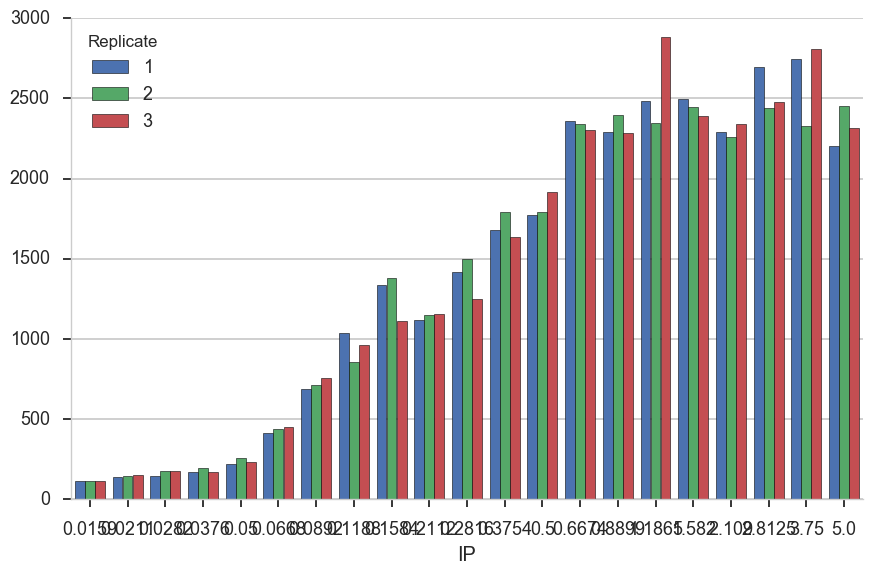

In [8]:
flow.BarChartView(statistic = ("ByIP", "geom_mean"),
                  variable = "IP",
                  huefacet = "Replicate").plot(ex2)

Bar charts are really best for categorical variables (with a modest number of categories.)  Let's do a line chart instead:

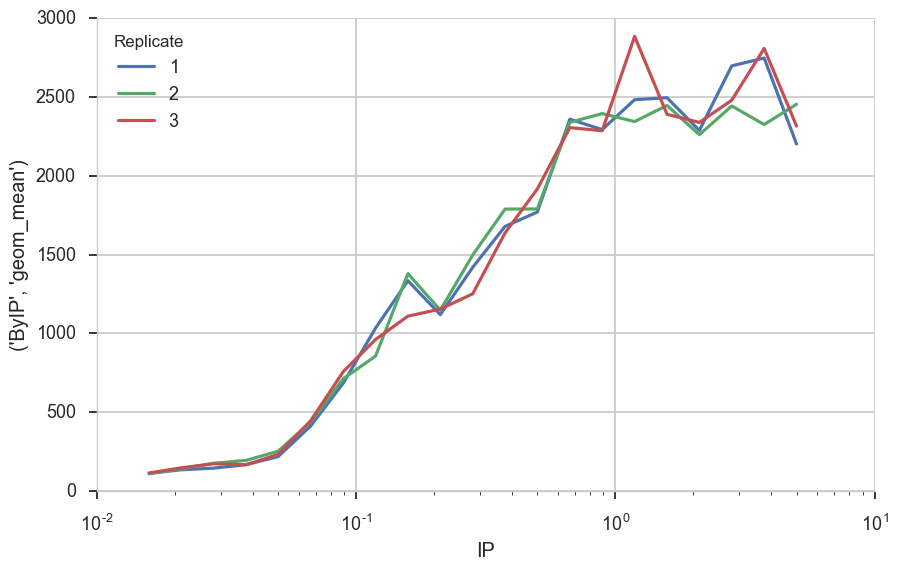

In [9]:
flow.Stats1DView(statistic = ("ByIP", "geom_mean"),
                 xvariable = "IP",
                 xscale = 'log',
                 huefacet = "Replicate").plot(ex2)

Statistics views can also plot error bars; the error bars must *also* be a statistic, and they must have the same indices as the "main" statistic.  For example, let's plot the geometric mean and geometric standard deviation of each IP subset:

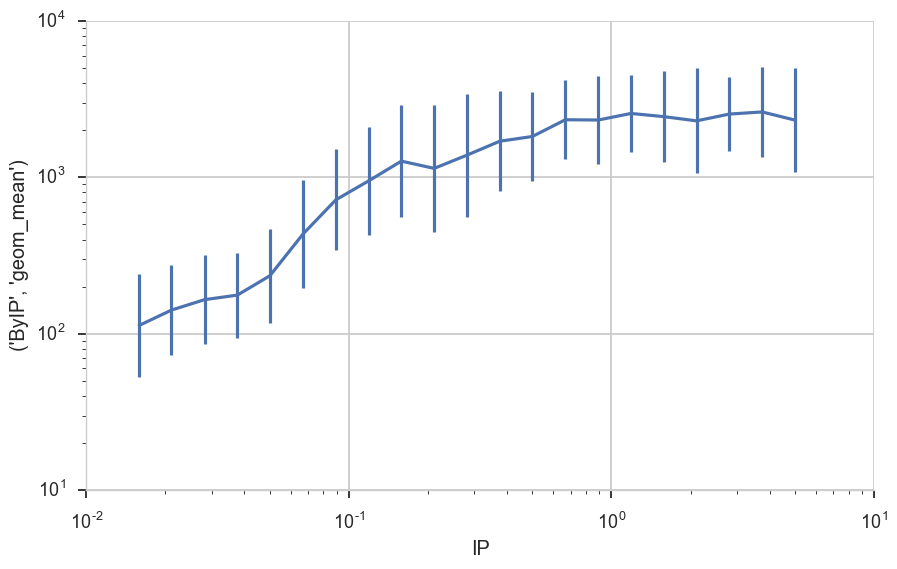

In [10]:
ex2 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ["IP"],
                              channel = "FITC-A",
                              function = flow.geom_mean).apply(ex)

# While an arithmetic SD is usually plotted plus-or-minus the arithmetic mean, 
# a *geometric* SD is usually plotted (on a log scale!) multiplied-or-divided by the 
# geometric mean.  the function geom_sd_range is a convenience function that does this.

ex3 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ['IP'],
                              channel = "FITC-A",
                              function = flow.geom_sd_range).apply(ex2)

flow.Stats1DView(statistic = ("ByIP", "geom_mean"),
                 xvariable = "IP",
                 xscale = "log",
                 yscale = "log",
                 error_statistic = ("ByIP", "geom_sd_range")).plot(ex3)

The plot above shows how one statistic varies (on the Y axis) as a variable changes on the X axis.  We can also plot two statistics against eachother.  For example, we can ask if the geometric standard deviation varies as the geometric mean changes:

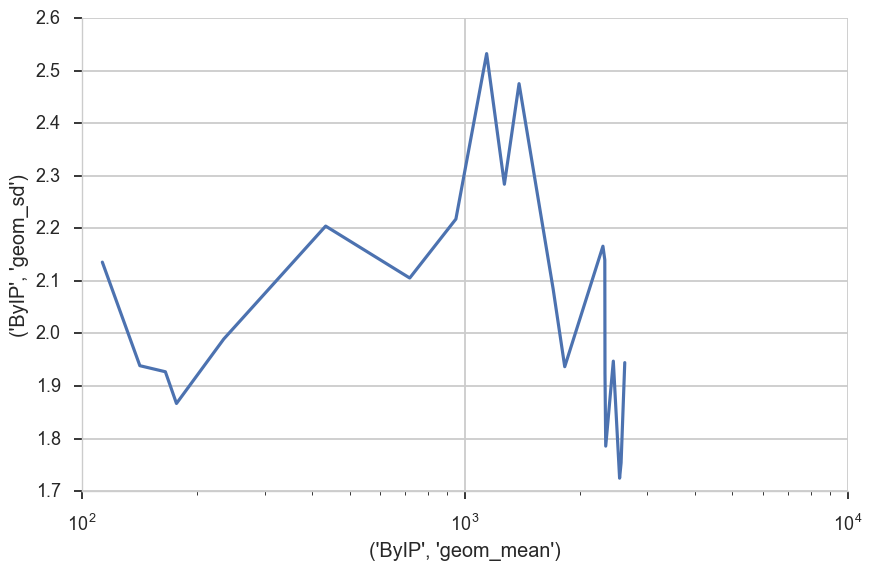

In [11]:
ex2 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ["IP"],
                              channel = "FITC-A",
                              function = flow.geom_mean).apply(ex)

ex3 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ['IP'],
                              channel = "FITC-A",
                              function = flow.geom_sd).apply(ex2)

flow.Stats2DView(variable = "IP",
                 xstatistic = ("ByIP", "geom_mean"),
                 ystatistic = ("ByIP", "geom_sd"),
                 xscale = "log").plot(ex3)

Nope, guess not.  See the **TASBE Calibrated Flow Cytometry** notebook for more examples of 1D and 2D statistics views.

---

# Transforming statistics

In addition to making statistics by applying summary functions to data, you can also apply functions to other statistics.  For example, a common question is "What percentage of my events are in a particular gate?"  We could, for instance, ask what percentage of events are above 1000 in the `FITC-A` channel, and how that varies by amount of `IP`. We start by defining a *threshold* gate with `ThresholdOp`:

In [12]:
thresh = flow.ThresholdOp(name = "Above1000",
                          channel = "FITC-A",
                          threshold = 1000)
ex2 = thresh.apply(ex)

Now, the `Experiment` has a condition named `Above1000` that is `True` or `False` depending on whether that event's `FITC-A` channel is greater than 1000.  Next, we compute the total number of events in each subset with a unique combination of `Above1000` and `IP`:

In [13]:
ex3 = flow.ChannelStatisticOp(name = "Above1000",
                              by = ["Above1000", "IP"],
                              channel = "FITC-A",
                              function = len).apply(ex2)
ex3.statistics[("Above1000", "len")]

Above1000  IP    
False      0.0159    300
           0.0211    300
           0.0282    298
           0.0376    298
           0.0500    297
           0.0668    257
           0.0892    187
           0.1188    151
           0.1584     93
           0.2112    111
           0.2816     81
           0.3754     50
           0.5000     45
           0.6674     20
           0.8899     21
           1.1865     19
           1.5820     21
           2.1090     28
           2.8125     13
           3.7500     12
           5.0000     29
True       0.0159      0
           0.0211      0
           0.0282      2
           0.0376      2
           0.0500      3
           0.0668     43
           0.0892    113
           0.1188    149
           0.1584    207
           0.2112    189
           0.2816    219
           0.3754    250
           0.5000    255
           0.6674    280
           0.8899    279
           1.1865    281
           1.5820    279
           2.1090    272
       

And now we compute the proportion of `Above1000 == True` for each value of `IP`.  `TransformStatisticOp` applies a function to subsets of a statistic; in this case, we're applying a `lambda` function to convert each `IP` subset from length into proportion.

In [14]:
import pandas as pd

ex4 = flow.TransformStatisticOp(name = "Above1000",
                                statistic = ("Above1000", "len"),
                                by = ["IP"],
                                function = lambda a: pd.Series(a / a.sum()),
                                statistic_name = "proportion").apply(ex3)

ex4.statistics[("Above1000", "proportion")][0:8]

IP      Above1000
0.0159  False        1.000000
        True         0.000000
0.0211  False        1.000000
        True         0.000000
0.0282  False        0.993333
        True         0.006667
0.0376  False        0.993333
        True         0.006667
dtype: float64

Now we can plot the new statistic.

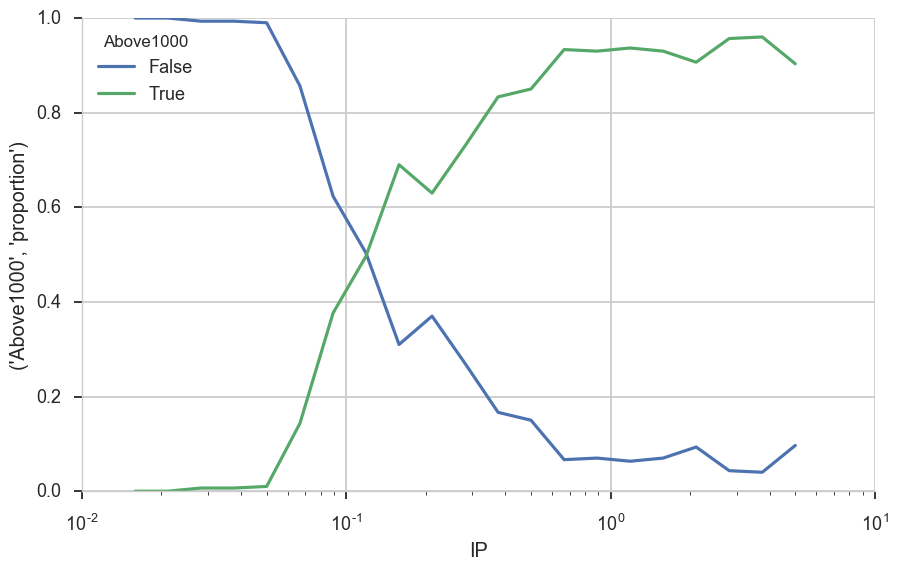

In [15]:
flow.Stats1DView(statistic = ("Above1000", "proportion"),
                 xvariable = "IP",
                 xscale = "log",
                 huefacet = "Above1000").plot(ex4)

Note that be default we get all the values in the statistic; in this case, it's both the proportion that's above 1000 (`True`) and the proportion that is below it (`False`).  We can pass a `subset` attribute to the `Stats1DView` to look at just one or the other. 

/home/brian/src/cytoflow/cytoflow/views/stats_1d.py:183: CytoflowViewWarning: Only one value for level Above1000; dropping it.


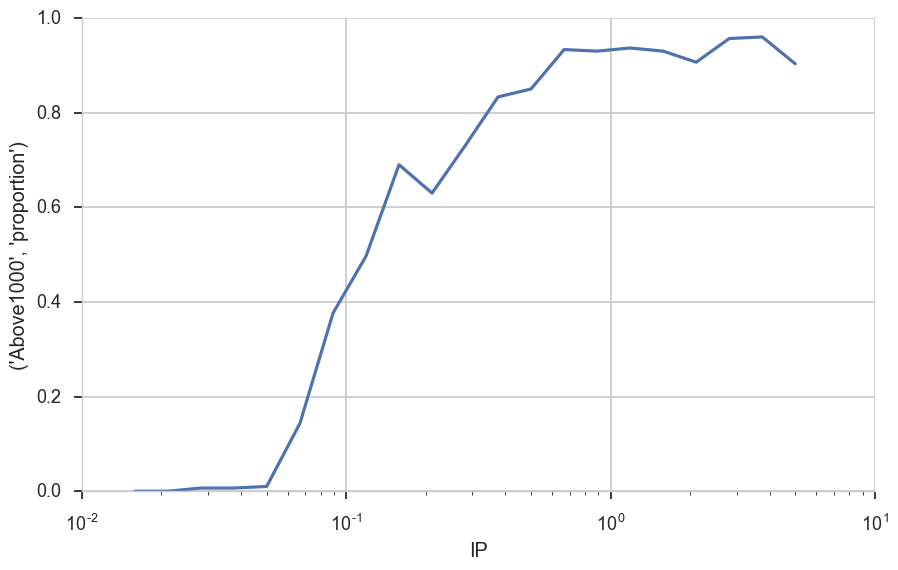

In [16]:
flow.Stats1DView(statistic = ("Above1000", "proportion"),
                 xvariable = "IP",
                 xscale = "log",
                 subset = "Above1000 == True").plot(ex4)

Note the warning.  Because the index level `Above1000` is always `True` in this subset, it gets dropped from the index.  Note also that we don't have to specify it as a variable or facet anywhere.

---

# Statistics from data-driven modules

One of the most exciting aspects of statistics in `cytoflow` is that other data-driven modules can add them to an `Experiment`, too.  For example, the `GaussianMixture1DOp` adds several statistics for each component of the mixture model it fits, containing the mean, standard deviation and proportion of observations in each component:

In [93]:
inputs = {
    "Yeast_B1_B01.fcs" : 5.0,
    "Yeast_B2_B02.fcs" : 3.75,
    "Yeast_B3_B03.fcs" : 2.8125,
    "Yeast_B4_B04.fcs" : 2.109,
    "Yeast_B5_B05.fcs" : 1.5820,
    "Yeast_B6_B06.fcs" : 1.1865,
    "Yeast_B7_B07.fcs" : 0.8899,
    "Yeast_B8_B08.fcs" : 0.6674,
    "Yeast_B9_B09.fcs" : 0.5,
    "Yeast_B10_B10.fcs" : 0.3754,
    "Yeast_B11_B11.fcs" : 0.2816,
    "Yeast_B12_B12.fcs" : 0.2112,
    "Yeast_C1_C01.fcs" : 0.1584,
    "Yeast_C2_C02.fcs" : 0.1188,
    "Yeast_C3_C03.fcs" : 0.0892,
    "Yeast_C4_C04.fcs" : 0.0668,
    "Yeast_C5_C05.fcs" : 0.05,
    "Yeast_C6_C06.fcs" : 0.0376,
    "Yeast_C7_C07.fcs" : 0.0282,
    "Yeast_C8_C08.fcs" : 0.0211,
    "Yeast_C9_C09.fcs" : 0.0159
}

tubes = []
for filename, ip in inputs.iteritems():
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip}))

    
ex = flow.ImportOp(conditions = {'IP' : "float"},
                   tubes = tubes).apply()

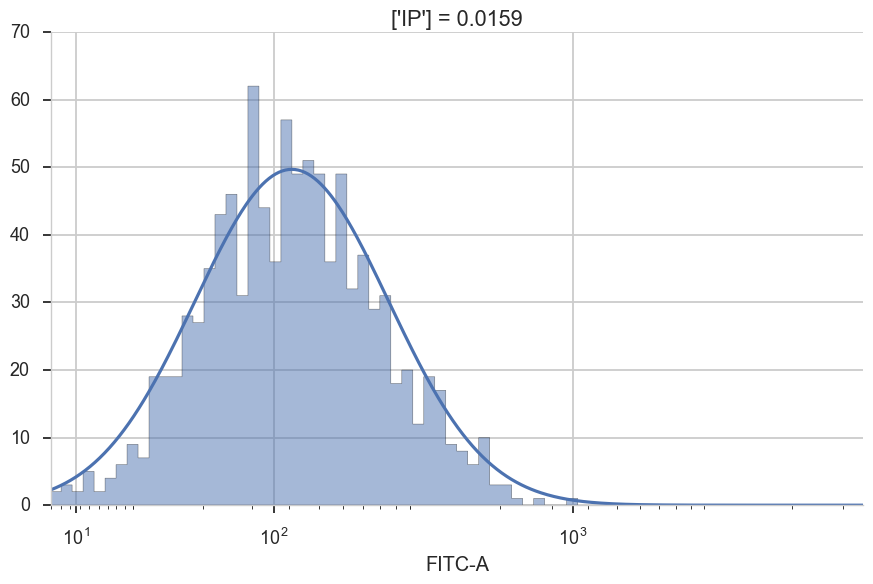

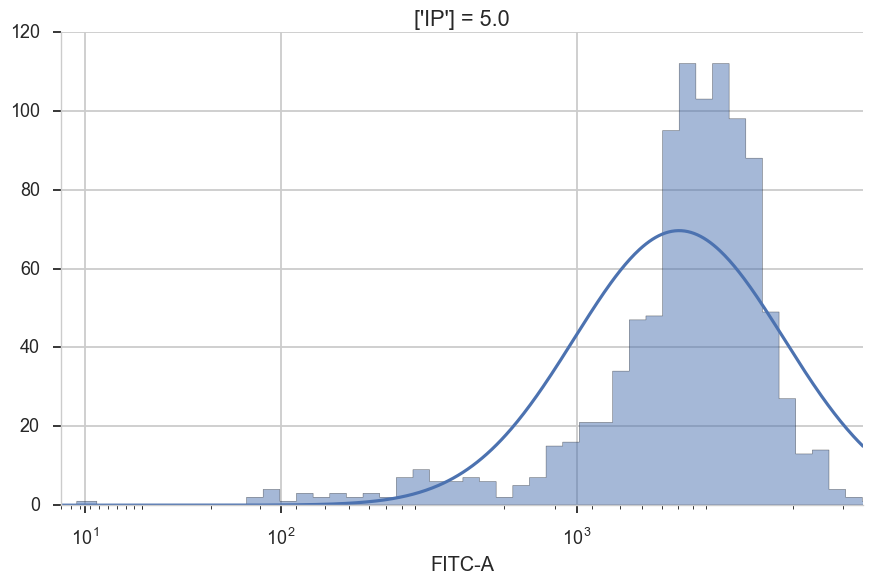

In [94]:
op = flow.GaussianMixture1DOp(name = "Gauss",
                              channel = "FITC-A",
                              by = ["IP"],
                              scale = "logicle")
op.estimate(ex)
ex2 = op.apply(ex)
op.default_view(subset = "IP == 0.0159 | IP == 5.0").plot(ex2)

In [97]:
ex2.statistics.keys()

[('Gauss', 'interval'), ('Gauss', 'stdev'), ('Gauss', 'mean')]

In [98]:
ex2.statistics[("Gauss", 'mean')]

IP
0.0159    114.868
0.0211    146.761
0.0282    161.832
0.0376    188.242
0.0500    252.534
0.0668    415.359
0.0892    675.336
0.1188    976.575
0.1584    1212.13
0.2112    1169.36
0.2816    1491.94
0.3754    1683.61
0.5000    1812.13
0.6674    2233.86
0.8899    2341.08
1.1865     2474.3
1.5820    2401.71
2.1090    2383.29
2.8125    2411.12
3.7500    2584.01
5.0000    2265.73
dtype: object

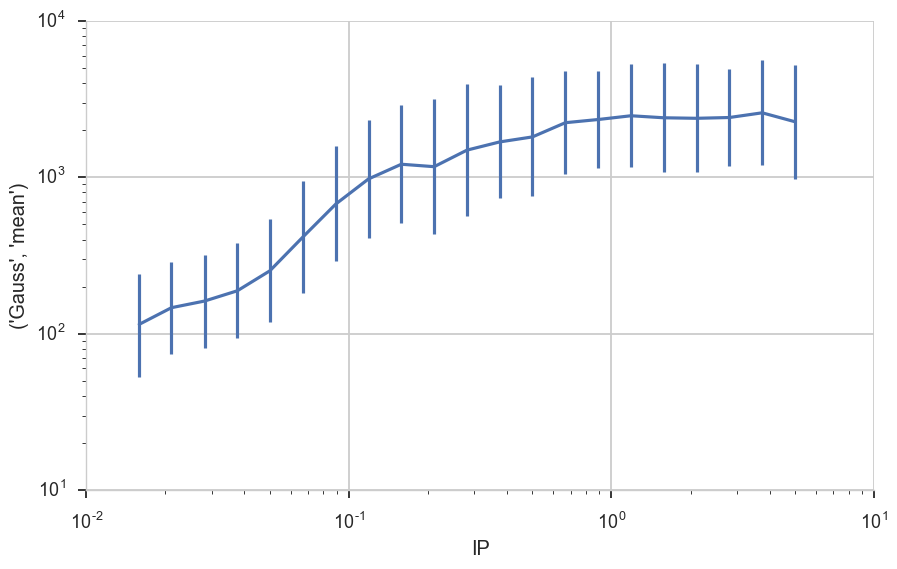

In [96]:
flow.Stats1DView(statistic = ("Gauss", "mean"),
                 xvariable = "IP",
                 xscale = "log",
                 yscale = "log",
                 error_statistic = ("Gauss", "interval")).plot(ex2)